In [ ]:
import pandas
print('pandas',pandas.__version__)
import numpy
print('numpy',numpy.__version__)
import glob
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
import time

# load data from pickle file

In [17]:
df = pandas.read_pickle("single_process_df_this_notebook_1552907228.209572.pkl")

In [18]:
print(df.shape)
df.head()

(10, 328)


,CPU 1 times guest,CPU 1 times guest_nice,CPU 1 times idle,CPU 1 times iowait,CPU 1 times irq,CPU 1 times nice,CPU 1 times softirq,CPU 1 times steal,CPU 1 times system,CPU 1 times user,...,system virtual memory buffers,system virtual memory cached,system virtual memory free,system virtual memory inactive,system virtual memory percent,system virtual memory shared,system virtual memory slab,system virtual memory total,system virtual memory used,time in unix seconds
0,0.0,0.0,2.9,0.0,0.0,0.0,3.8,0.0,26.9,66.3,...,65462272,1438371840,81920000,1287057408,32.4,786432,85819392,2096164864,510410752,1.552907e+09
1,0.0,0.0,96.2,0.0,0.0,0.0,0.0,0.0,1.9,1.9,...,65462272,1438388224,81539072,1287057408,32.4,786432,85852160,2096164864,510775296,1.552907e+09
2,0.0,0.0,90.4,0.0,0.0,0.0,0.0,0.0,1.9,7.7,...,65462272,1438388224,81539072,1287057408,32.4,786432,85852160,2096164864,510775296,1.552907e+09
3,0.0,0.0,98.1,0.9,0.0,0.0,0.0,0.0,0.9,0.0,...,65474560,1438388224,81031168,1287053312,32.4,786432,85852160,2096164864,511270912,1.552907e+09
4,0.0,0.0,98.1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,65474560,1438388224,80523264,1287053312,32.4,786432,85852160,2096164864,511778816,1.552907e+09


# drop column if entire column is constant value

In [19]:
# https://stackoverflow.com/questions/39658574/how-to-drop-columns-which-have-same-values-in-all-rows-via-pandas-or-spark-dataf
series_of_unique_values_per_column = df.apply(pandas.Series.nunique)
cols_to_drop = series_of_unique_values_per_column[series_of_unique_values_per_column == 1].index
df = df.drop(cols_to_drop, axis=1)
print(df.shape)
df.head()

(10, 35)


,CPU 1 times idle,CPU 1 times iowait,CPU 1 times softirq,CPU 1 times system,CPU 1 times user,CPU 2 times idle,CPU 2 times system,CPU 2 times user,CPU percent for 0,CPU percent for 1,...,system virtual memory active,system virtual memory available,system virtual memory buffers,system virtual memory cached,system virtual memory free,system virtual memory inactive,system virtual memory percent,system virtual memory slab,system virtual memory used,time in unix seconds
0,2.9,0.0,3.8,26.9,66.3,8.0,42.0,45.0,97.3,92.2,...,614408192,1417768960,65462272,1438371840,81920000,1287057408,32.4,85819392,510410752,1.552907e+09
1,96.2,0.0,0.0,1.9,1.9,95.2,1.0,3.8,3.8,4.8,...,614907904,1417404416,65462272,1438388224,81539072,1287057408,32.4,85852160,510775296,1.552907e+09
2,90.4,0.0,0.0,1.9,7.7,94.0,2.0,2.0,9.6,4.1,...,614907904,1417404416,65462272,1438388224,81539072,1287057408,32.4,85852160,510775296,1.552907e+09
3,98.1,0.9,0.0,0.9,0.0,93.4,0.9,5.7,0.9,6.6,...,615391232,1416892416,65474560,1438388224,81031168,1287053312,32.4,85852160,511270912,1.552907e+09
4,98.1,0.0,0.0,1.0,1.0,96.1,2.9,1.0,1.9,3.9,...,615849984,1416384512,65474560,1438388224,80523264,1287053312,32.4,85852160,511778816,1.552907e+09


# scatter plot per column

In [23]:
def scatter_plot_column(df,col_name):
    if not isinstance(df,pandas.core.frame.DataFrame):
        raise TypeError('ERROR: expected input of type dataframe, got',type(df))
        return None
    print(col_name)
    x=df['time in unix seconds']
    y=df[col_name]
    # https://stackoverflow.com/questions/31126698/differences-between-scipy-stats-linregress-numpy-polynomial-polynomial-polyfi
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    print('r',r_value)
    print('p',p_value)
    print('std error:',std_err)

    _=plt.figure(figsize=(5,4))
    if (abs(1-r_value)<0.01):
        plt.scatter(x,y,label='original')
        plt.plot(x, intercept + slope*x, 'r', label='fitted line')
        linear=True
    else:
        plt.plot_date(x=df['datetime'],y=df[col_name],label='original')
        plt.xticks(rotation=40)
        linear=False
    
    _=plt.ylabel(col_name,fontsize=14)
    _=plt.xlabel('time',fontsize=14)
    plt.show()
    return linear

CPU 1 times idle
r 0.565899596242
p 0.0881601954572
std error: 2.75040919139


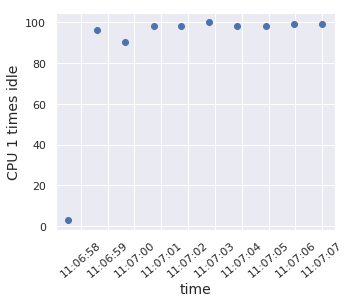

CPU 1 times iowait
r -0.172028889543
p 0.634627041843
std error: 0.0311584475986


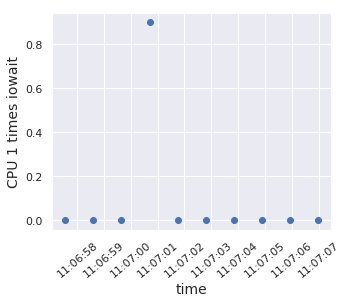

CPU 1 times softirq
r -0.522641329098
p 0.121159596286
std error: 0.113857426519


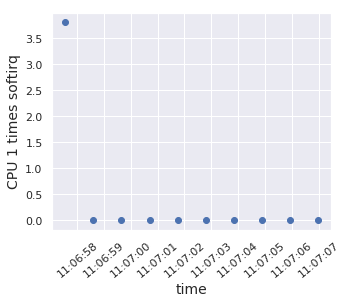

CPU 1 times system
r -0.549791648317
p 0.0996765845185
std error: 0.760008404846


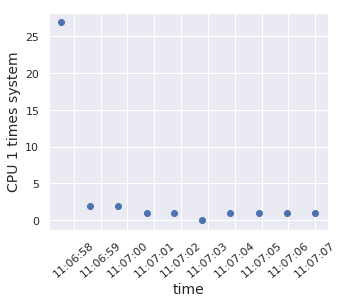

CPU 1 times user
r -0.570841376236
p 0.084806571136
std error: 1.88495845331


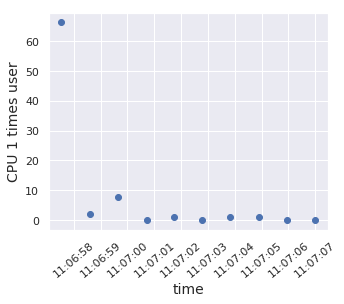

CPU 2 times idle
r 0.53210700118
p 0.113370348803
std error: 2.58992521089


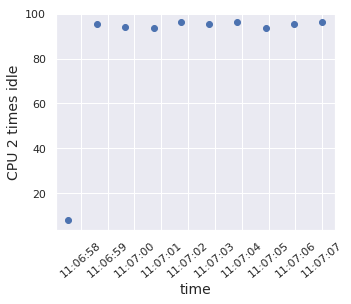

CPU 2 times system
r -0.516718532841
p 0.126198382619
std error: 1.21240798873


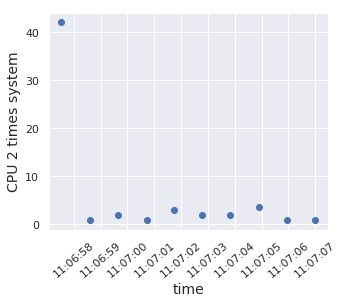

CPU 2 times user
r -0.528560731027
p 0.116250712026
std error: 1.25952678954


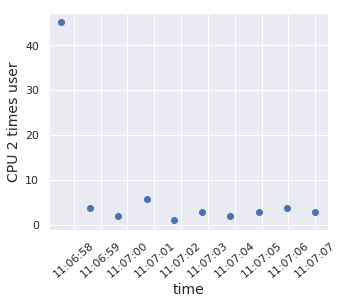

CPU percent for 0
r -0.563273457862
p 0.089976425999
std error: 2.76577304682


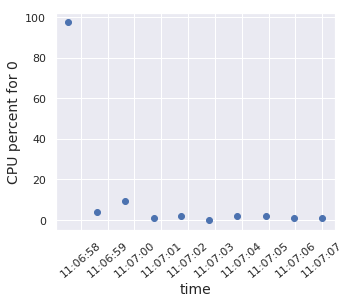

CPU percent for 1
r -0.524491985148
p 0.119611261552
std error: 2.61661581647


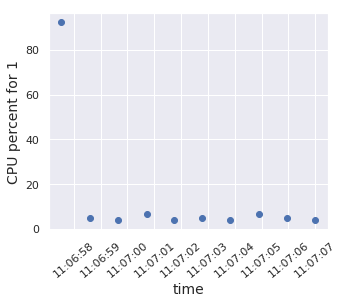

CPU stats ctx_switches
r 0.926583231767
p 0.000116245047182
std error: 54.5254564757


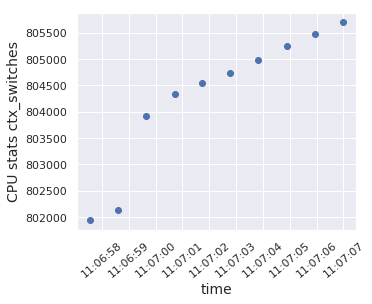

CPU stats interrupts
r 0.926470283269
p 0.000116945762325
std error: 28.4200302292


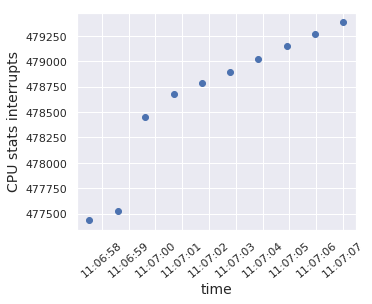

CPU stats soft_interrupts
r 0.995381439877
p 1.97968204869e-09
std error: 3.19809146349


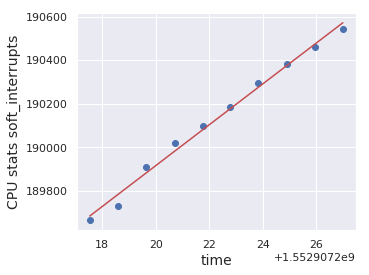

datetime
process cpu times: system
r 0.984135467471
p 2.71891224837e-07
std error: 0.000665421041986


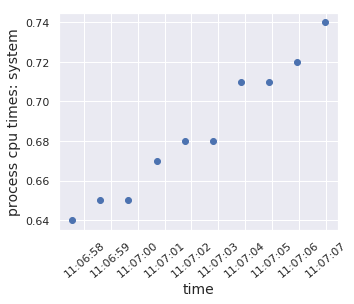

process cpu times: user
r 0.981321452248
p 5.20694065599e-07
std error: 0.00141118107275


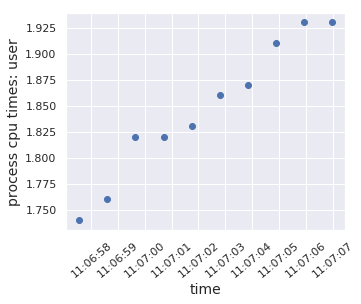

process io counters: read_chars
r 0.999996272803
p 8.44316793982e-22
std error: 450.865413183


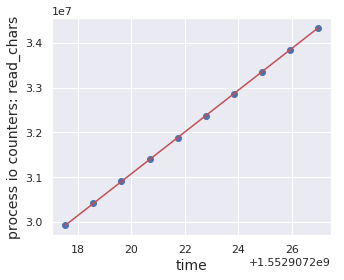

process io counters: read_count
r 0.999996272803
p 8.44316793881e-22
std error: 0.19751791331


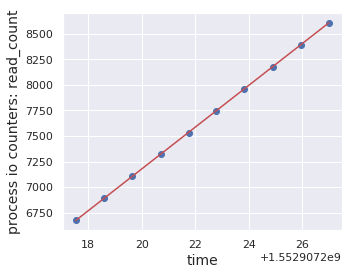

process memory: data
r 0.948371898648
p 2.91983950395e-05
std error: 25501.4659558


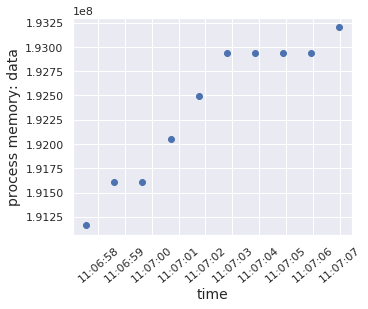

process memory: pss
r 0.939081686352
p 5.59580382558e-05
std error: 29275.746252


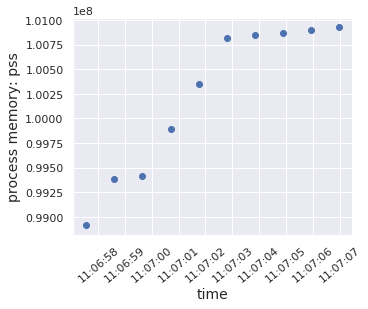

process memory: rss
r 0.944908149169
p 3.76983840809e-05
std error: 28433.8872724


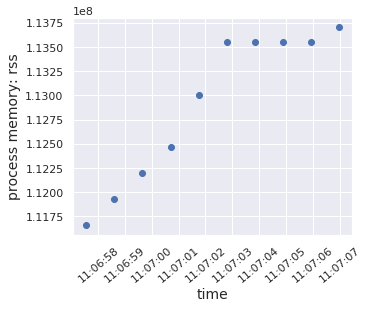

process memory: uss
r 0.939081686352
p 5.59580382558e-05
std error: 29275.746252


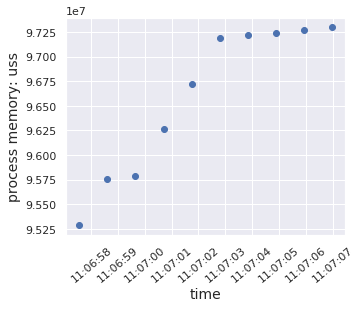

process memory: vms
r 0.948371898648
p 2.91983950395e-05
std error: 25501.4659558


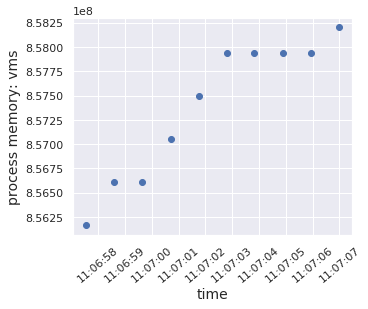

process number context switches: involuntary
r 0.986682295832
p 1.35437194807e-07
std error: 0.147613474704


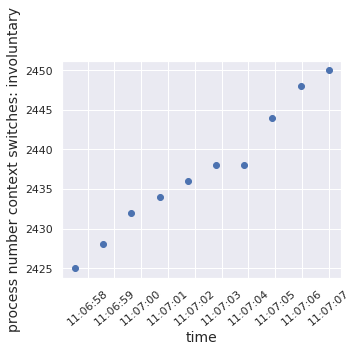

process number context switches: voluntary
r 0.999996272803
p 8.44316793881e-22
std error: 0.000918687968883


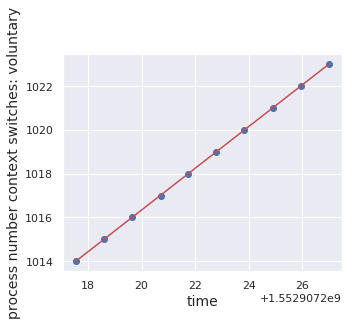

system virtual memory active
r 0.939659254443
p 5.39040633949e-05
std error: 29269.2301049


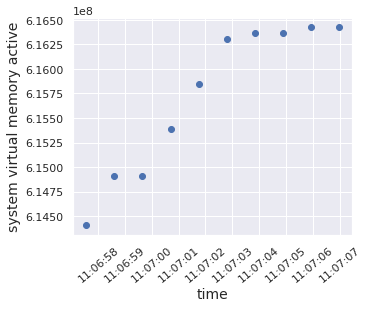

system virtual memory available
r -0.935546115988
p 6.98202765626e-05
std error: 29716.9194825


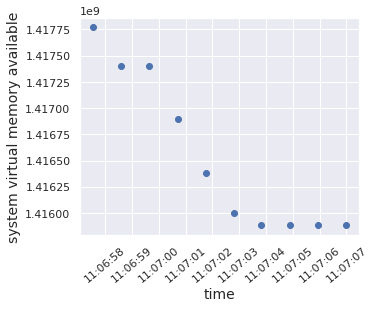

system virtual memory buffers
r 0.798698411516
p 0.00558999662978
std error: 396.943709534


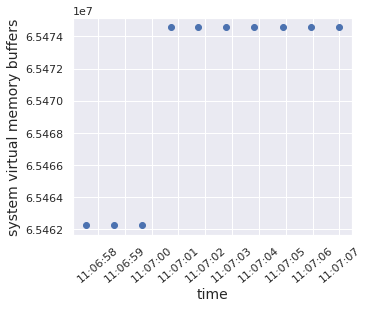

system virtual memory cached
r -0.384887375825
p 0.27208777966
std error: 719.584428989


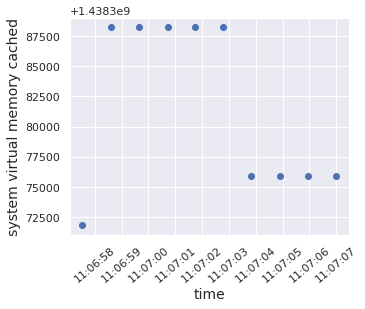

system virtual memory free
r -0.934683123874
p 7.35573602655e-05
std error: 29831.4200962


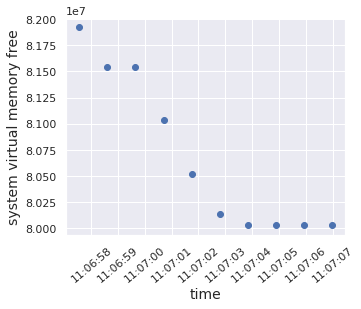

system virtual memory inactive
r -0.798698411516
p 0.00558999662978
std error: 132.314569845


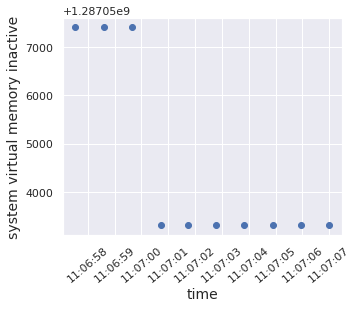

system virtual memory percent
r 0.852243862312
p 0.00173781000263
std error: 0.0030023600008


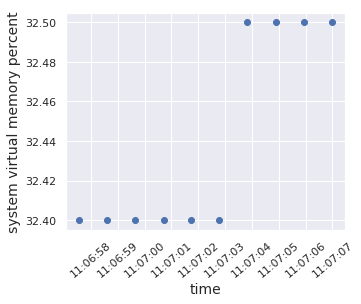

system virtual memory slab
r -0.745550184425
p 0.0133118064756
std error: 2864.56014474


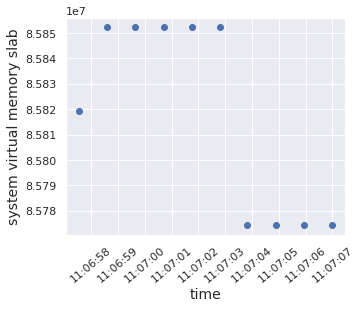

system virtual memory used
r 0.936414198468
p 6.62047332289e-05
std error: 29307.2004504


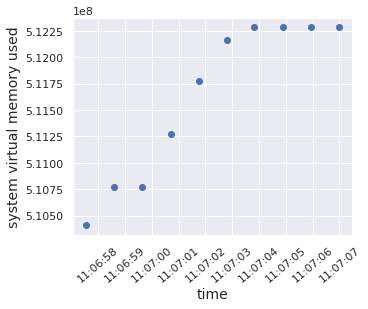

time in unix seconds


In [24]:
list_of_linear_columns=[]
for col_name in df.columns:
    if ('seconds' in col_name) or ('datetime' in col_name):
        print(col_name)
    else:
#        plt.scatter(x=df['time in unix seconds'],y=df[col_name])
        linear_bool = scatter_plot_column(df,col_name)
        if (linear_bool):
            list_of_linear_columns.append(col_name)

# drop columns that are linear

In [ ]:
list_of_linear_columns

In [ ]:
df = df.drop(list_of_linear_columns, axis=1)
print(df.shape)
df.head()

# find correlated columns and drop all but one of the correlated columns

https://stackoverflow.com/questions/39409866/correlation-heatmap


In [ ]:
df.columns

evaluate correlation for one pair

In [ ]:
df['CPU 1 times idle'].corr(df['process memory: rss'])

calculate the correlation matrix

In [ ]:
corr = df.corr()
corr.head()

In [ ]:
seaborn.set(rc={'figure.figsize':(10,8)})
# plot the heatmap 
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
_=seaborn.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)#, annot=True)

# diagonal is 1, indicating perfect correlation
# black means anti-correlated

which columns are correlated?

In [ ]:
type(corr)

In [ ]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# Select upper triangle of correlation matrix
upper = corr.where(numpy.triu(numpy.ones(corr.shape), k=1).astype(numpy.bool))
#upper.head()

In [ ]:
for column in upper.columns:
    #print('column:',column)
    for row in upper.index:
        #print('row:',row)
        #print(upper[column].loc[row])
        if (upper[column].loc[row] > 0.999):
            print(column,'|',row,'|',upper[column].loc[row])
            _=scatter_plot_column(df,column)
            _=scatter_plot_column(df,row)

In [ ]:
seaborn.set(rc={'figure.figsize':(5,4)})
_=seaborn.regplot(x=df['CPU 1 times idle'], y=df['CPU 1 times softirq'])